In [1]:
# import pystan
import stanity
n_jobs = 4
import pandas as pd
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import norm, truncnorm

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8e66b04252e7dda9281ce8f26cd55007 NOW.


NOT reusing model.
Ran in 52.819 sec.
Inference for Stan model: anon_model_8e66b04252e7dda9281ce8f26cd55007.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     -0.02  6.1e-4   0.03  -0.08  -0.04  -0.02 2.9e-3   0.05   2683    1.0
sigma   1.02  4.3e-4   0.02   0.98    1.0   1.02   1.03   1.06   2789    1.0
lp__  -521.4    0.02   0.95 -523.9 -521.7 -521.1 -520.7 -520.4   2528    1.0

Samples were drawn using NUTS at Wed Nov  2 10:01:11 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


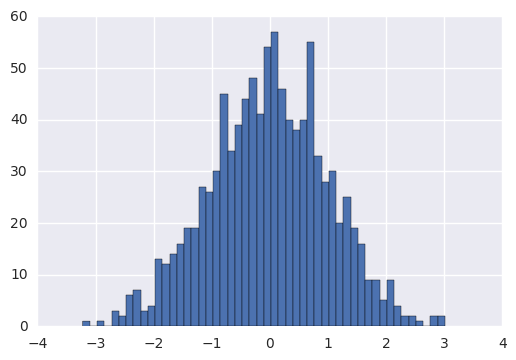

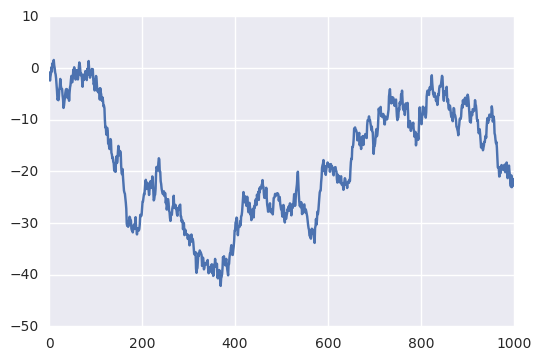

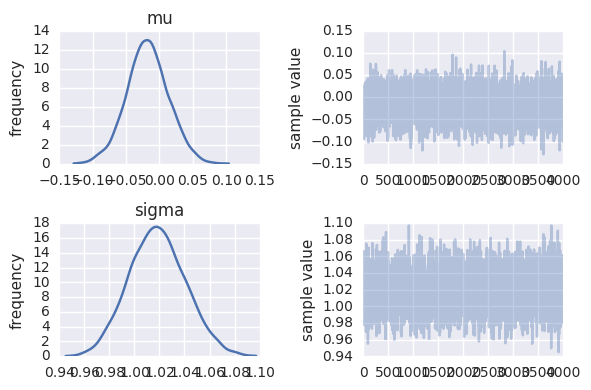

In [4]:
#### Random walk
mu = 0
sigma = 1
n = 1000

data = norm(loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real mu;
    real<lower = 0> sigma;
    
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        Y[t+1] ~ normal(mu+Y[t],sigma);
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7955e186edc1a57d41230efb2263b3d3 NOW.


NOT reusing model.
Ran in 48.033 sec.
Inference for Stan model: anon_model_7955e186edc1a57d41230efb2263b3d3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.01  1.3e-3   0.07   3.88   3.97   4.01   4.06   4.14   2356    1.0
sigma   1.96  1.0e-3   0.05   1.86   1.92   1.96   1.99   2.06   2562    1.0
lp__   -2016    0.02    1.0  -2018  -2016  -2015  -2015  -2015   1916    1.0

Samples were drawn using NUTS at Wed Nov  2 10:02:02 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


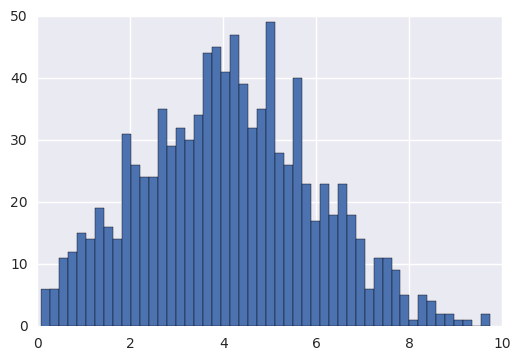

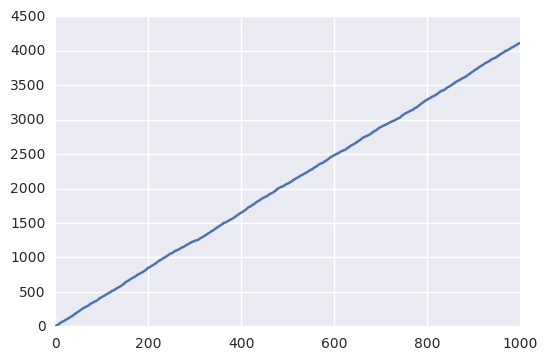

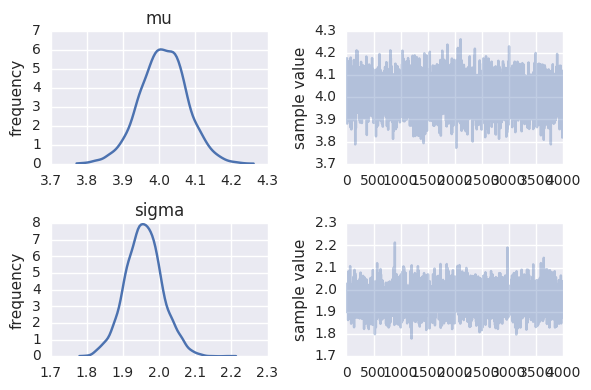

In [5]:
#### Random walk, positive steps
mu = 4
sigma = 2
n = 1000


a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
  
data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower=0> mu;
    real<lower = 0> sigma;
    
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        target += normal_lpdf( Y[t+1]-Y[t] | mu, sigma);
        target += -normal_lccdf(0 | mu, sigma);
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

Reusing model.
Ran in 3.050 sec.
Inference for Stan model: anon_model_7350368b1eaf8cbe024e025c45b4d6db.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      5.01  1.5e-3   0.07   4.88   4.97   5.01   5.06   5.15   2180    1.0
sigma   2.01  1.0e-3   0.05   1.91   1.97    2.0   2.04   2.11   2433    1.0
theta    0.8  2.4e-4   0.01   0.77   0.79    0.8   0.81   0.82   2712    1.0
lp__   -1457    0.03   1.19  -1460  -1458  -1457  -1456  -1456   1799    1.0

Samples were drawn using NUTS at Wed Nov  2 09:07:56 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


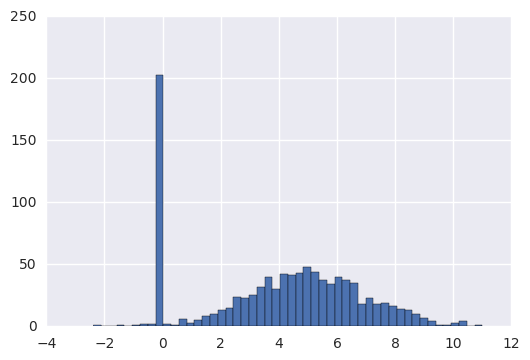

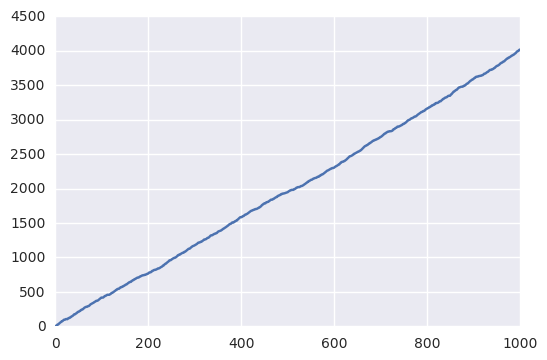

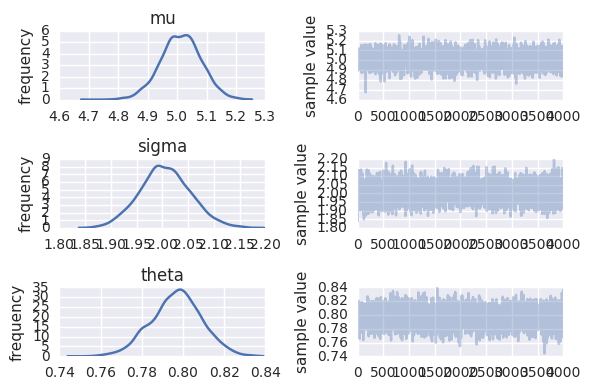

In [18]:
### Random walk, possibility of no step

theta = .8
mu = 5
sigma = 2
n = 1000

improvement = rand(n)<theta

data = norm(loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
  
data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real mu;
    real<lower = 0> sigma;
    real<lower=0, upper=1> theta;
    
}

model {
    theta ~ normal(theta_prior_location, theta_prior_scale);

    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        target += log_mix(theta, normal_lpdf(Y[t+1]-Y[t] | mu, sigma), 
                      normal_lpdf(Y[t+1]-Y[t] | 0, 0.01));
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'theta_prior_location': .5,
       'theta_prior_scale': 1,
       'mu_prior_location': 0,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55966d7cbcb107a5050fe4d2db5fb265 NOW.


NOT reusing model.
Ran in 51.356 sec.
Inference for Stan model: anon_model_55966d7cbcb107a5050fe4d2db5fb265.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.99  6.6e-4   0.04   4.91   4.96   4.99   5.01   5.06   3007    1.0
sigma   1.03  4.9e-4   0.03   0.98   1.01   1.03   1.05   1.08   2853    1.0
theta    0.8  2.1e-4   0.01   0.77   0.79    0.8   0.81   0.82   3219    1.0
lp__  -775.9    0.03   1.23 -779.2 -776.4 -775.6 -775.0 -774.6   2110    1.0

Samples were drawn using NUTS at Wed Nov  2 10:02:55 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


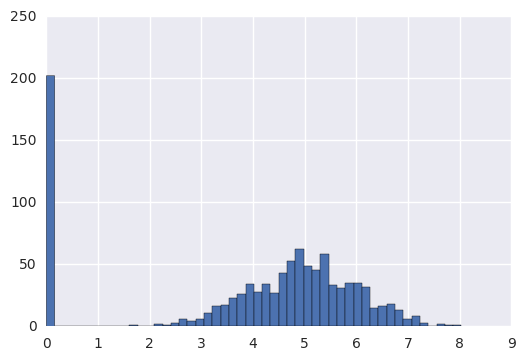

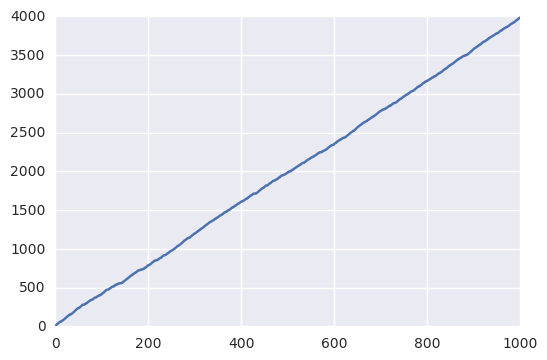

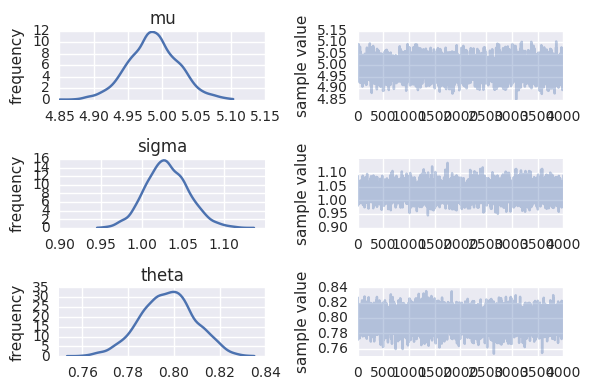

In [6]:
### Random walk, possibility of no step, positive steps, noise on no step

theta = .8
mu = 5
sigma = 1
n = 1000

improvement = rand(n)<theta

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions {
  real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    //real out;
    //if(x<=A) {
    //  out = log(0);
    //} else {
    //  out = normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma);
    //}
    //return(out);
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
  }
}

data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower=0> mu;
    real<lower=0> sigma;
    real<lower=0, upper=1> theta;
    
}

model {
    theta ~ normal(theta_prior_location, theta_prior_scale);

    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        target += log_mix(theta, lower_truncated_normal_lpdf(Y[t+1]-Y[t] | mu, sigma, 0), 
                      lower_truncated_normal_lpdf(Y[t+1]-Y[t] | 0, 0.01, 0));
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'theta_prior_location': .5,
       'theta_prior_scale': 1,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b13cdc51ac03f26bda5bd61f7c201b28 NOW.


NOT reusing model.
Ran in 49.103 sec.
Inference for Stan model: anon_model_b13cdc51ac03f26bda5bd61f7c201b28.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       5.0  6.0e-4   0.03   4.93   4.98    5.0   5.02   5.07   3087    1.0
sigma   0.98  4.3e-4   0.02   0.94   0.97   0.98    1.0   1.03   3004    1.0
theta   0.79  2.2e-4   0.01   0.77   0.78   0.79    0.8   0.81   3132    1.0
lp__   -1622    0.03   1.18  -1625  -1622  -1621  -1621  -1620   1924    1.0

Samples were drawn using NUTS at Wed Nov  2 10:03:46 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


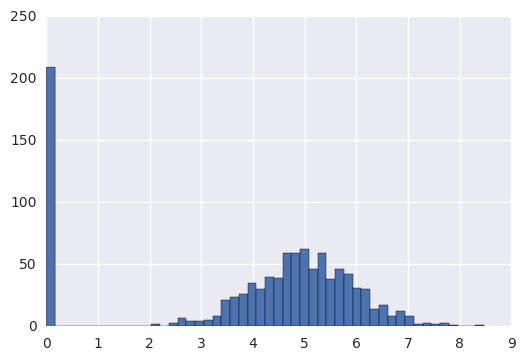

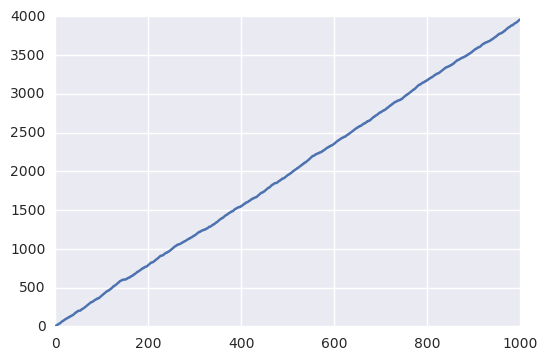

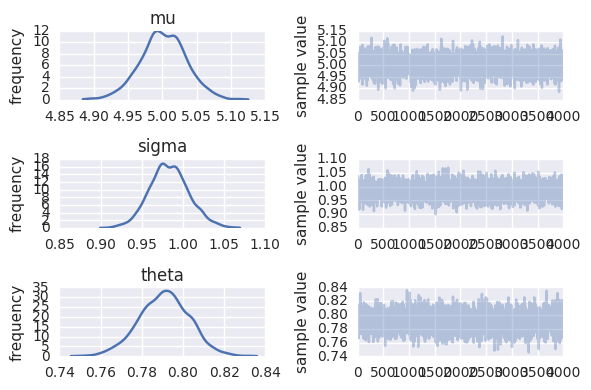

In [7]:
### Random walk, possibility of no step, positive steps, no noise on no step

theta = .8
mu = 5
sigma = 1
n = 1000

improvement = rand(n)<theta

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions {
  real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    //real out;
    //if(x<=A) {
    //  out = log(0);
    //} else {
    //  out = normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma);
    //}
    //return(out);
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
  }
}

data {
    int T; // number of time periods
    vector[T] Y; // value each time period
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower=0> mu;
    real<lower=0> sigma;
    real<lower=0, upper=1> theta;
    
}

model {
    theta ~ normal(theta_prior_location, theta_prior_scale);

    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    for(t in 1:(T-1)) {
        if((Y[t+1]-Y[t])==0) {
          target += log(1-theta);
        } else {
          target += lower_truncated_normal_lpdf(Y[t+1]-Y[t] | mu, sigma, 0) + log(theta);
          }
    }

}
"""

stan_data = {'T': len(time_series),
       'Y': time_series,
       'theta_prior_location': .5,
       'theta_prior_scale': 1,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)
print(model_fit)
model_fit.plot()
tight_layout()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08b41a59ad90bcfe68ca6667d8a42ad8 NOW.


NOT reusing model.
Ran in 153.328 sec.


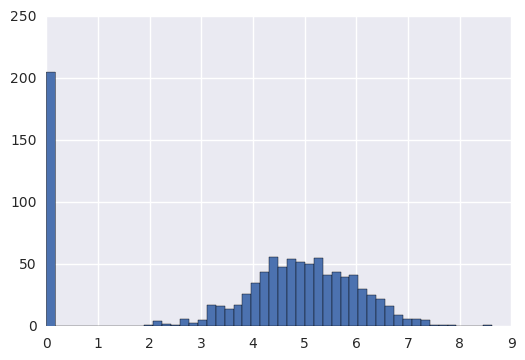

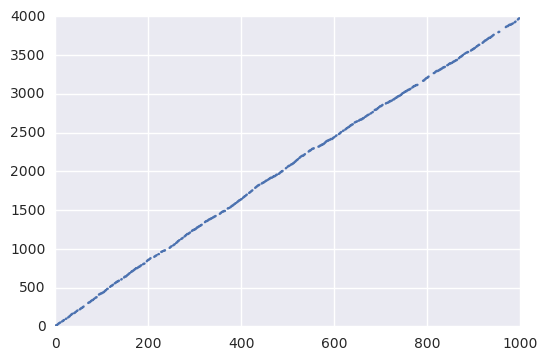

In [37]:
### Random walk, possibility of no step, positive steps, noise on no step, missing data

p_missing = .3
theta = .8
mu = 5
sigma = 1
n = 1000

improvement = rand(n)<theta

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
time_series[missing]=nan


hist(data, bins=50)
figure()
plot(time_series)

model_code = """
functions {
  real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
  }
}

data {
    int N; // number of time periods
    vector[N] Y; // value each time period
    
    real theta_prior_location; 
    real theta_prior_scale; 
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
}

parameters {
    real<lower=0> mu;
    real<lower=0> sigma;
    real<lower=0, upper=1> theta;
    
    vector<lower = 0>[N-1] r; // updates

    
}

transformed parameters {
  vector[N] latent_Y;
  
  latent_Y[1] = Y[1];
  
  for(t in 2:N) {
    latent_Y[t] = latent_Y[t-1] + r[t-1];
  }
}

model {
    theta ~ normal(theta_prior_location, theta_prior_scale);

    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    
    for(t in 2:N) {
        target += log_mix(theta, lower_truncated_normal_lpdf(r[t-1] | mu, sigma, 0.0), 
                      lower_truncated_normal_lpdf(r[t-1] | 0.0, 0.01, 0.0));
                      
        if(Y[t] > -900) {
            target += normal_lpdf( latent_Y[t]| Y[t], 0.01); // measurement error
            //latent_Y[t] ~ normal(Y[t], 0.001) T[0,]
        }
    }

}
"""

stan_data = {'N': len(time_series),
       'Y': pd.Series(time_series).fillna(-999),
       'theta_prior_location': .5,
       'theta_prior_scale': 1,
       'mu_prior_location': 3,
       'mu_prior_scale': 1,
       'sigma_prior_location': 0,
       'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code, data=stan_data, n_jobs=n_jobs)

In [41]:
print(model_fit)

Inference for Stan model: anon_model_08b41a59ad90bcfe68ca6667d8a42ad8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu              4.32    1.77   2.51    0.5   1.97   4.86   6.57   7.06      2    nan
sigma           0.84    0.45   0.64   0.23   0.36   0.61   1.37   1.91      2    nan
theta           0.42    0.16   0.23   0.18    0.2   0.39   0.65   0.72      2    nan
r[0]            5.27    1.93   2.73   2.29   3.23   4.52   7.28  10.03      2  66.79
r[1]            1.06    0.46   0.66   0.33   0.45   0.95    1.7   2.01      2    nan
r[2]            1.57    1.07   1.51   0.26   0.46   0.94    2.8   4.14      2 521.08
r[3]            5.39    3.43   4.85   0.19   0.85   4.35   9.78  12.57      2  41.97
r[4]            4.49    4.36   6.16   0.17    0.2   1.37   9.39  15.04      2    nan
r[5]            1.25    1.11   1.57   0.25   0

(0, 25.0)

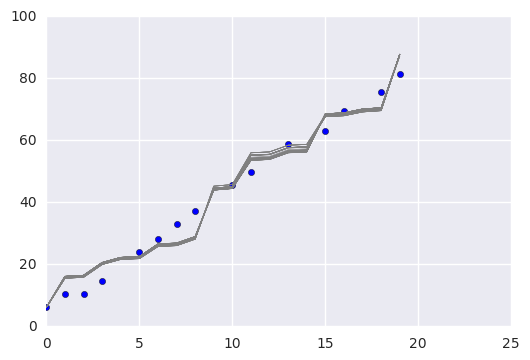

In [38]:
n_T = 20
plot(model_fit['latent_Y'][:50,:n_T].T,linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
ylim(ymin=0)
xlim(xmin=0)

(0, 20.0)

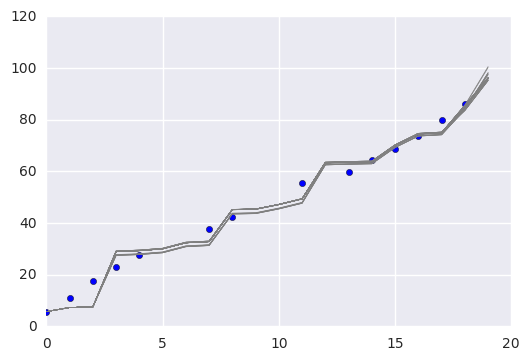

In [27]:
n_T = 20
plot(model_fit['latent_Y'][:50,:n_T].T,linewidth=.5, color='gray')
scatter(arange(n_T), time_series[:n_T])
ylim(ymin=0)
xlim(xmin=0)

In [ ]:
print(model_fit)
model_fit.plot()
tight_layout()

figure()
model_fit.extract('latent_Y').plot(linewidth=.5, color='gray')
scatter(time_series)